In [4]:
import os
import pickle
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

train_data_path = '../data/train'
test_data_path = '../data/test'

train_files = os.listdir(train_data_path)
test_files = os.listdir(test_data_path)

vitals_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
lab_features = ['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']
demographic_features = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
target = 'SepsisLabel'

In [5]:
dynamic_features = vitals_features + lab_features
take_max_cols = ['SepsisLabel', 'Age', 'Gender', 'ICULOS']

def preprocessing(dfs: list[pd.DataFrame], interactions=True):
    patient_vecs = []
    with tqdm(total=len(dfs)) as pbar:
        for i in range(len(dfs)):
            _df = dfs[i]
            _mean = _df[dynamic_features].mean().add_suffix('_mean')
            _rolling_mean = _df[dynamic_features].rolling(3).mean().mean().add_suffix('_rolling_mean')
            _diff_mean = _df[dynamic_features].diff().mean().add_suffix('_diff_mean')
            _median = _df[dynamic_features].median().add_suffix('_median')
            _mean_minus_median = (_df[dynamic_features].mean() - _df[dynamic_features].median()).add_suffix('_mean_minus_median')
            _std = _df[dynamic_features].std().add_suffix('_std')
            _sem = _df[dynamic_features].sem().add_suffix('_sem')
            _range = (_df[dynamic_features].max() - _df[dynamic_features].min()).add_suffix('_range')
            _max1 = _df[vitals_features].max().add_suffix('_max')
            _max2 = _df[['SepsisLabel', 'Gender', 'Age', 'ICULOS']].max()
            _skew  = _df[dynamic_features].skew().add_suffix('_skew')
            _pvec = pd.concat([_mean, _rolling_mean, _diff_mean, _range, _std, _sem, _median, _mean_minus_median, _max1, _max2, _skew], axis=0)
            patient_vecs.append(_pvec)
            pbar.update(1)


    _df = pd.DataFrame(patient_vecs)
    _df.reset_index(drop=True, inplace=True)

    if interactions:
        for f1 in vitals_features:
            for f2 in vitals_features:
                if f1 != f2 and f1 + '_mean' in _df and f2 + '_mean' in _df:
                    f1_mean = _df[f1 + '_mean']
                    f2_mean = _df[f2 + '_mean']
                    _df[f'log_{f1}_mean_x_{f2}_mean'] = np.log(1+f1_mean) * np.log(1+f2_mean)
                    _df[f'{f1}_mean_over_{f2}_mean'] = f1_mean / (1+f2_mean)
                    _df[f'{f1}_skew_x_{f2}_skew'] = _df[f1+'_skew'] * _df[f2+'_skew']

    return _df

In [6]:
def read_dataframes(data_path:str) -> list[pd.DataFrame]:
    _dfs = []
    _files = os.listdir(data_path)
    with tqdm(total=len(_files)) as pbar:
        for f in _files:
            _dfs.append(pd.read_csv(os.path.join(data_path, f), sep='|'))
            pbar.update(1)
    print(f'Found {len(_dfs)} dataframes in {data_path}')
    return _dfs

### Load training data

In [7]:
train_dfs = read_dataframes(train_data_path)

100%|██████████| 20000/20000 [01:20<00:00, 247.15it/s]

Found 20000 dataframes in ../data/train


In [8]:
train_df = preprocessing(train_dfs)

100%|██████████| 20000/20000 [06:55<00:00, 48.11it/s]
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_6799/1131820091.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'log_{f1}_mean_x_{f2}_mean'] = np.log(1+f1_mean) * np.log(1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_6799/1131820091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'{f1}_mean_over_{f2}_mean'] = f1_mean / (1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_6799/1131820091.py:36: Performance

In [9]:
features = list(train_df.columns)
features.remove(target)
f'{len(features)} training features'

'485 training features'

In [10]:
test_dfs = read_dataframes(test_data_path)

100%|██████████| 10000/10000 [00:38<00:00, 260.48it/s]

Found 10000 dataframes in ../data/test


In [11]:
test_df = preprocessing(test_dfs)

100%|██████████| 10000/10000 [03:19<00:00, 50.00it/s]
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_6799/1131820091.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'log_{f1}_mean_x_{f2}_mean'] = np.log(1+f1_mean) * np.log(1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_6799/1131820091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _df[f'{f1}_mean_over_{f2}_mean'] = f1_mean / (1+f2_mean)
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_6799/1131820091.py:36: Performance

In [12]:
test_data = xgb.DMatrix(test_df[features])

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [13]:
train_df[features + [target]]

,HR_mean,O2Sat_mean,Temp_mean,SBP_mean,MAP_mean,DBP_mean,Resp_mean,EtCO2_mean,BaseExcess_mean,HCO3_mean,...,log_EtCO2_mean_x_MAP_mean,EtCO2_mean_over_MAP_mean,EtCO2_skew_x_MAP_skew,log_EtCO2_mean_x_DBP_mean,EtCO2_mean_over_DBP_mean,EtCO2_skew_x_DBP_skew,log_EtCO2_mean_x_Resp_mean,EtCO2_mean_over_Resp_mean,EtCO2_skew_x_Resp_skew,SepsisLabel
0,93.150000,96.500000,36.633333,134.175000,99.100000,88.200000,18.675000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,84.656250,94.156250,36.380000,155.750000,95.687500,63.593750,15.233333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,76.490000,97.761905,37.383333,123.020833,85.778125,NaN,18.846939,NaN,NaN,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,75.474359,96.115385,37.252174,119.538462,72.243590,50.179487,18.355263,NaN,-0.400000,24.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,95.833333,99.416667,36.571429,145.722222,81.259259,62.037037,19.714286,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,82.360000,95.240000,37.167143,157.364583,87.677083,54.322581,16.340426,NaN,0.750000,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
19996,71.000000,97.000000,36.833333,123.250000,78.500000,65.250000,20.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
19997,92.666667,97.523810,37.220000,121.404762,78.142857,61.166667,18.142857,NaN,0.666667,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
19998,68.690476,97.190476,36.683333,138.119048,96.119048,78.309524,15.350000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


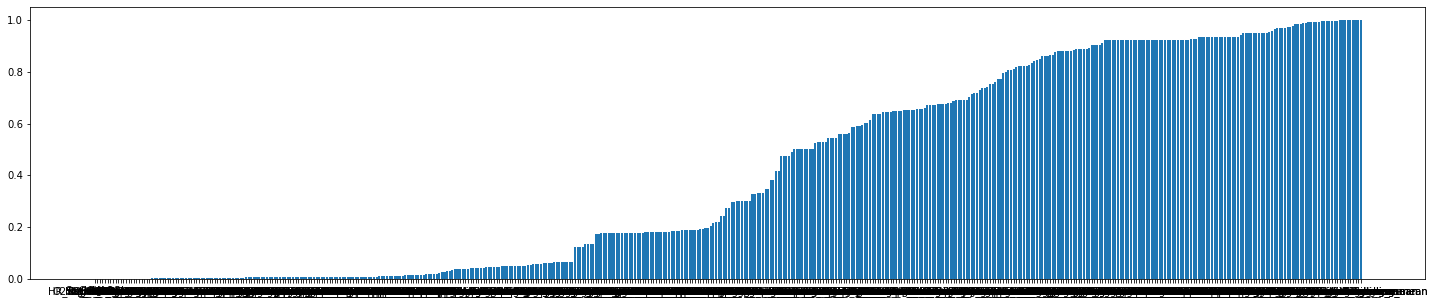

In [27]:
missing_values = (train_df.isna().sum() / len(train_df)).sort_values()
plt.figure(figsize=(25,5))
plt.bar(missing_values.index, missing_values.values)
plt.xticks = None
plt.show()

In [15]:
alpha = 0.933
weights = alpha * train_df[target] + (1-alpha) * (1-train_df[target])
print('Weighted average of target values (0.5=balanced):')
sum(weights * train_df[target]) / sum(weights)

Weighted average of target values (0.5=balanced):


0.5146176604726499

In [16]:
train_data = xgb.DMatrix(train_df[features], label=train_df[target], weight=weights)

/Users/snirlugassy/miniconda3/envs/deep/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [17]:
training_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'map'],
    # 'booster': 'dart', # default=gbtree
    # 'rate_drop': 0.1, # default=0
    # 'lambda': 1, # default=0
    # 'learning_rate': 0.01, # default=0.3
    # 'max_depth': 7, # default=6
}

NUM_ROUNDS = 128

In [18]:
# TODO: use xgb_model param for continous training
bst = xgb.train(params=training_params, dtrain=train_data, num_boost_round=NUM_ROUNDS)

In [19]:
y_predict_train = bst.predict(train_data)
y_predict_train, type(y_predict_train)

(array([0.00202353, 0.00091269, 0.00353945, ..., 0.00861697, 0.00069432,
        0.00040886], dtype=float32),
 numpy.ndarray)

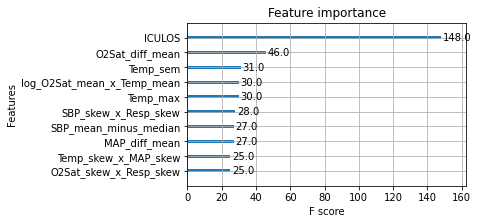

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(5,3)
xgb.plot_importance(bst, ax, max_num_features=10)
plt.show()

In [21]:
y_predict_train_label = 1 * (y_predict_train >= 0.5)
f1_score(train_df[target], y_predict_train_label)

0.9922861150070127

In [31]:
bst.save_model('model_004.json')

# Test

In [22]:
y_predict_test = bst.predict(test_data)

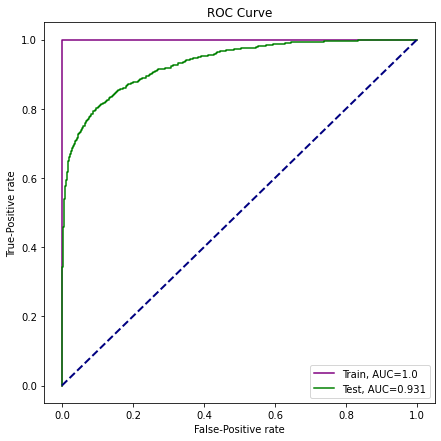

In [23]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_true=train_df[target], y_score=y_predict_train)
test_fpr, test_tpr, test_thresholds = roc_curve(y_true=test_df[target], y_score=y_predict_test)

train_auc_score = roc_auc_score(y_true=train_df[target], y_score=y_predict_train)
test_auc_score = roc_auc_score(y_true=test_df[target], y_score=y_predict_test)

plt.figure(figsize=(7,7))
plt.title('ROC Curve')
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.plot(train_fpr, train_tpr, color='purple', label='Train')
plt.plot(test_fpr, test_tpr, color='green', label='Test')
plt.legend([f'Train, AUC={train_auc_score:.3}', f'Test, AUC={test_auc_score:.3}'])
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()


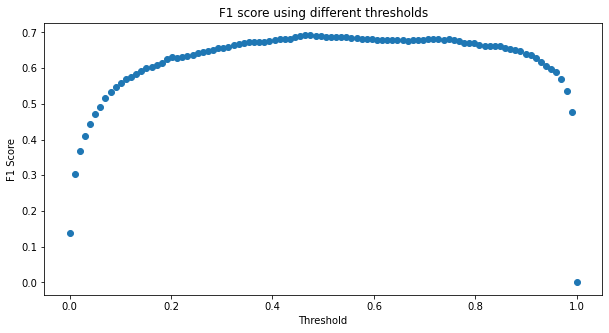

In [24]:
thresholds = np.linspace(0,1,100)
_f1 = [f1_score(y_true=test_df[target], y_pred=1*(y_predict_test >= t)) for t in thresholds]

plt.figure(figsize=(10,5))
plt.title('F1 score using different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.scatter(thresholds, _f1)
plt.show()

In [33]:
max_f1 = max(_f1)
optimal_threshold = thresholds[_f1.index(max_f1)]
print('max test f1:', max_f1, 'at threshold:', optimal_threshold)

max test f1: 0.6917080085046067 at threshold: 0.4646464646464647
